<a href="https://colab.research.google.com/github/ahmedahmedov/AInotebooks/blob/master/fastai_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fastai Installation and Set Up

In [11]:
!nvidia-smi

Sat Nov  6 16:28:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install fastai==2.5.3


In [127]:
import fastai

In [265]:
fastai.__version__

'2.5.3'

In [ ]:
import torch
torch.__version__

'1.9.0+cu111'

# Fastai Tabular

In [260]:
from fastai.tabular.all import *

In [261]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/export.pkl')]

In [262]:
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/export.pkl')]

In [263]:
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt  ... hours-per-week  native-country salary
0   49            Private  101320  ...             40   United-States  >=50k
1   44            Private  236746  ...             45   United-States  >=50k
2   38            Private   96185  ...             32   United-States   <50k
3   38       Self-emp-inc  112847  ...             40   United-States  >=50k
4   42   Self-emp-not-inc   82297  ...             50   United-States   <50k

[5 rows x 15 columns]

* Load Tabular Data from a CSV file. 
* Set the prediction variable to salary. 
* Set the batch size to 25. 
* Set the workclass, education, marital-status, occupation, relationship and race features as categorical. 
* Set age, fnlwgt, education-num as continuous variables. 
* Preprocess using Categorify, Missing Value Imputation and Normalization     
    * Normalization -> def encodes(self, x:TensorImage): return (x-self.mean) / self.std


In [266]:
dls_tabular = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary", bs = 25,
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [267]:
dls_tabular.show_batch()

Check the torch vision and make sure that it is cuda-based

In [245]:
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt  ... hours-per-week  native-country salary
0   49            Private  101320  ...             40   United-States  >=50k
1   44            Private  236746  ...             45   United-States  >=50k
2   38            Private   96185  ...             32   United-States   <50k
3   38       Self-emp-inc  112847  ...             40   United-States  >=50k
4   42   Self-emp-not-inc   82297  ...             50   United-States   <50k

[5 rows x 15 columns]

In [247]:
len(df.education.unique())

16

In [268]:
df.education.unique()

array([' Assoc-acdm', ' Masters', ' HS-grad', ' Prof-school', ' 7th-8th',
       ' Some-college', ' 11th', ' Bachelors', ' Assoc-voc', ' 10th',
       ' 9th', ' Doctorate', ' 12th', ' 1st-4th', ' 5th-6th',
       ' Preschool'], dtype=object)

In [269]:
learn_tabular = tabular_learner(dls_tabular, metrics=[accuracy],layers=[50,10])

In [270]:
learn_tabular.save('model_tabular.pkl')

Path('/root/.fastai/data/adult_sample/models/model_tabular.pkl.pth')

In [271]:
learn_tabular.summary()

TabularModel (Input shape: 25 x 7)
Layer (type)         Output Shape         Param #    Trainable 
                     25 x 6              
Embedding                                 60         True      
____________________________________________________________________________
                     25 x 8              
Embedding                                 136        True      
____________________________________________________________________________
                     25 x 5              
Embedding                                 40         True      
____________________________________________________________________________
                     25 x 8              
Embedding                                 128        True      
____________________________________________________________________________
                     25 x 5              
Embedding                                 35         True      
_______________________________________________________________

In [272]:
learn_tabular.fit_one_cycle(5)

In [253]:
learn_tabular.show_results()

In [274]:
test_df = df.copy()
test_df.drop(['salary'], axis=1, inplace=True)
dl = learn_tabular.dls.test_dl(test_df)

In [275]:
learn_tabular.get_preds(dl=dl)

(tensor([[0.6576, 0.3424],
         [0.5607, 0.4393],
         [0.7529, 0.2471],
         ...,
         [0.6791, 0.3209],
         [0.8312, 0.1688],
         [0.9025, 0.0975]]), None)

To further expose what's going on below the surface, let's rewrite this utilizing fastai's TabularPandas class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [276]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [308]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary', y_block = CategoryBlock()
                   splits=splits)

In [309]:
dls_tabular = to.dataloaders(bs=64)


In [310]:
dls_tabular.show_batch()


We can define a model using the tabular_learner method. When we define our model, fastai will try to infer the loss function based on our y_names earlier.

Note: Sometimes with tabular data, your y's may be encoded (such as 0 and 1). In such a case you should explicitly pass y_block = CategoryBlock in your constructor so fastai won't presume you are doing regression.

In [311]:
learn_tabular = tabular_learner(dls_tabular, metrics=accuracy)

In [315]:
dls_tabular.show_batch()

In [312]:
learn_tabular.fit_one_cycle(3)


In [313]:
learn_tabular.show_results()

In [317]:
row, clas, probs = learn_tabular.predict(df.iloc[0])
row, clas, probs

(   workclass  education  marital-status  ...    fnlwgt  education-num  salary
 0        5.0        8.0             3.0  ... -0.846174       0.751533     1.0
 
 [1 rows x 11 columns], tensor(1), tensor([0.3906, 0.6094]))

In [318]:
row.show()


In [319]:
clas, probs


(tensor(1), tensor([0.3906, 0.6094]))

# Fastai vision


## Imports and Dataset set up

In [ ]:
from fastai.vision.all import *

The dataset can be downloaded and decompressed with this line of code:

untar - un - tape archive

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/models'),Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
files = get_image_files(path/"images")
len(files)

7390

In [ ]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_13.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_107.jpg'))

Plot top losses function is buggy. I had to create an alternative version

In [ ]:
def plot_top_losses_debug(interp, k=9, largest=true, **kwargs):
    if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
    if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
    else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
    k=9
    b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
    x,y,its = interp.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
    x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses, figsize=(20,20))

## Single-label classification

### Simple dummy binary classification

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the .ls() method.

We can then define an easy label function:

In [156]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a DataLoaders object. Here we have a function that labels using the file names, so we will use ImageDataLoaders.from_name_func

In [218]:
dls_binary = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

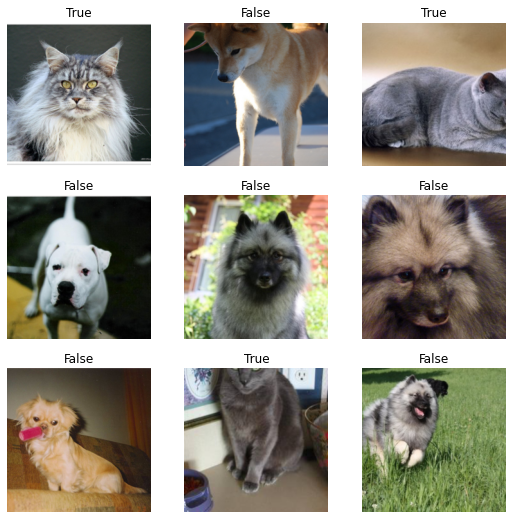

In [219]:
dls_binary.show_batch()

Then we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [221]:
learn_binary = cnn_learner(dls_binary, resnet34, metrics=[error_rate,accuracy])
learn_binary.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [174]:
learn_binary.fine_tune(1)

In [222]:
learn_binary.predict(files[0])

('True', tensor(1), tensor([3.4548e-04, 9.9965e-01]))

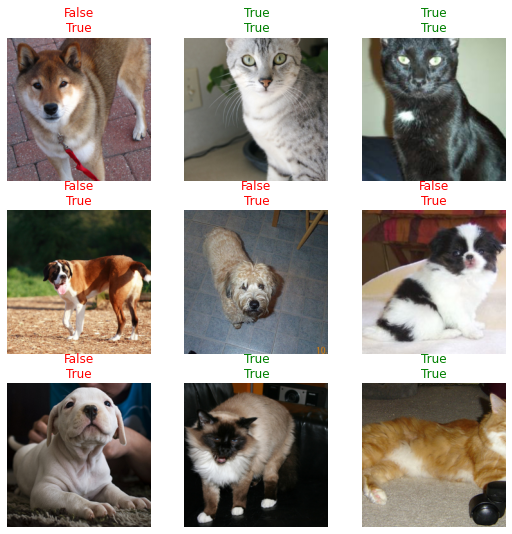

In [223]:
learn_binary.show_results()

In [224]:
interp_binary = Interpretation.from_learner(learn_binary)

In [227]:
losses,idx = interp_binary.top_losses(9, True)
interp_binary.from_learner(learn_binary)

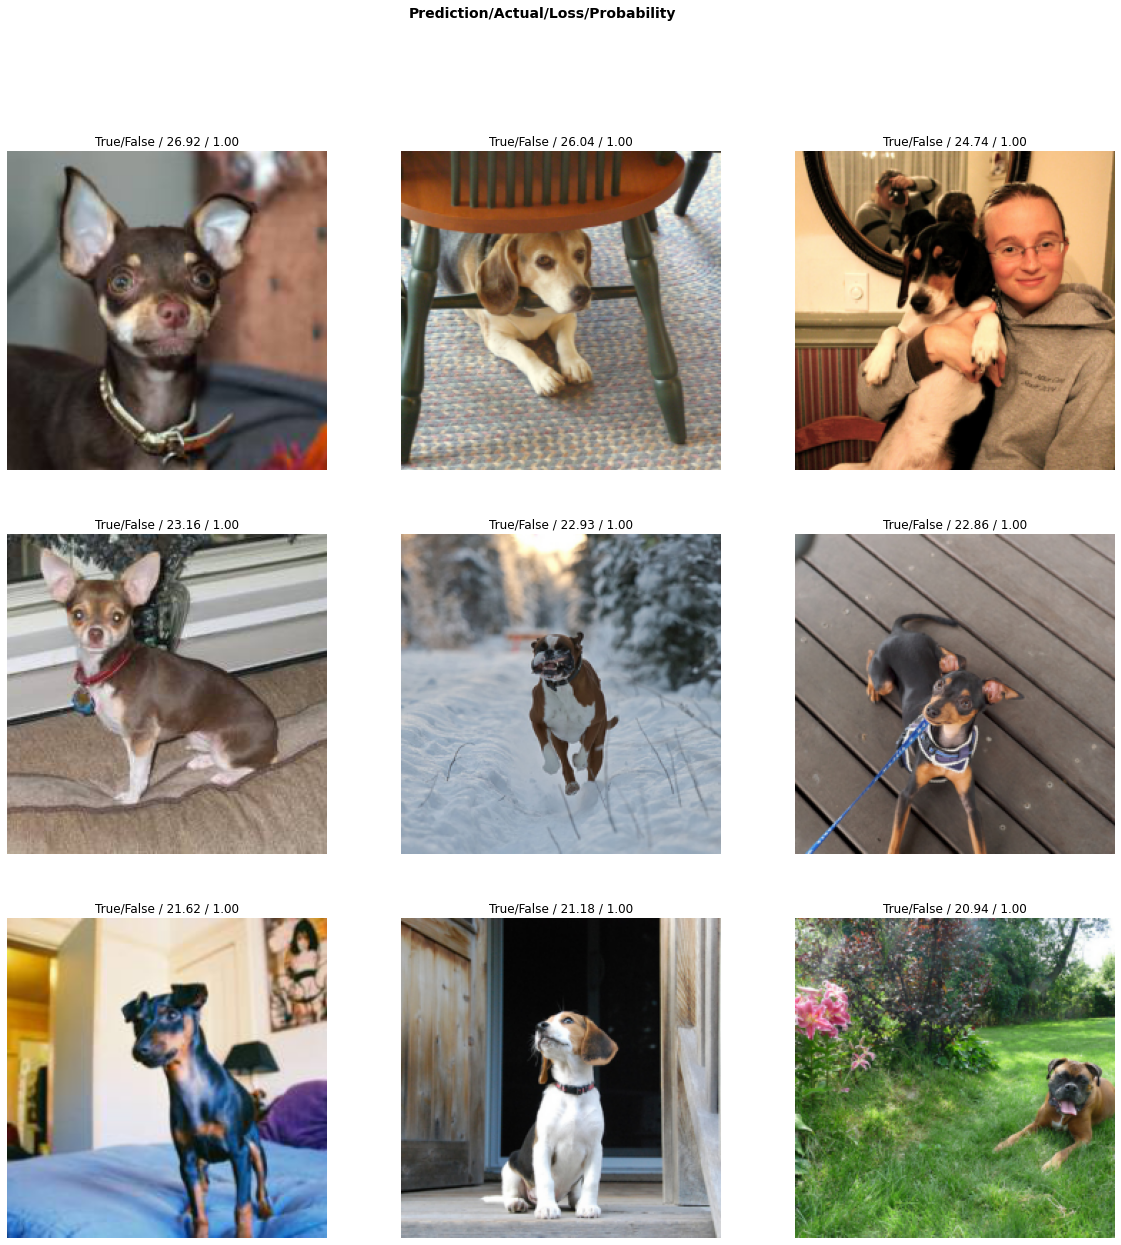

In [229]:
plot_top_losses_debug(interp_binary,largest=True, figsize=(20,20))

In [185]:

def plot_top_losses_heatmap(k,learner, largest= True,figsize=(15,11)):
    tl_val,tl_idx = interp.top_losses(k,largest)
    print (tl_idx)
    classes = interp.data.classes
    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
    for i,idx in enumerate(tl_idx):
        im,cl = interp.data.valid_ds[idx]
        cl = int(cl)
        ###
        xb,_ = data.one_item(im)
        xb = xb.cuda()
        m = learner.model.eval()
        with hook_output(m[0]) as hook_a:
            with hook_output(m[0], grad= True) as hook_g:
                preds = m(xb)
                preds[0,cl].backward()
        acts = hook_a.stored[0].cpu()
        avg_acts =acts.mean(0)
        sz = im.shape[-1]
        im.show(ax=axes.flat[i], title=
            f'{classes[interp.pred_class[idx]]}/{classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
        axes.flat[i].imshow(avg_acts, alpha =0.6, extent= (0,sz,sz,0), interpolation='bilinear', cmap='magma')


### Classifying breeds

To label our data with the breed name, we will use a regular expression to extract it from the filename. Looking back at a filename, we have:

In [165]:
files[0].name

'Birman_13.jpg'

A regular expression that will catch the name is:

In [230]:
#regex for name
pat = r'^(.*)_\d+.jpg'

Since it's pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:

In [231]:
dls_breeds = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

we can then use show_batch to have a look at our data

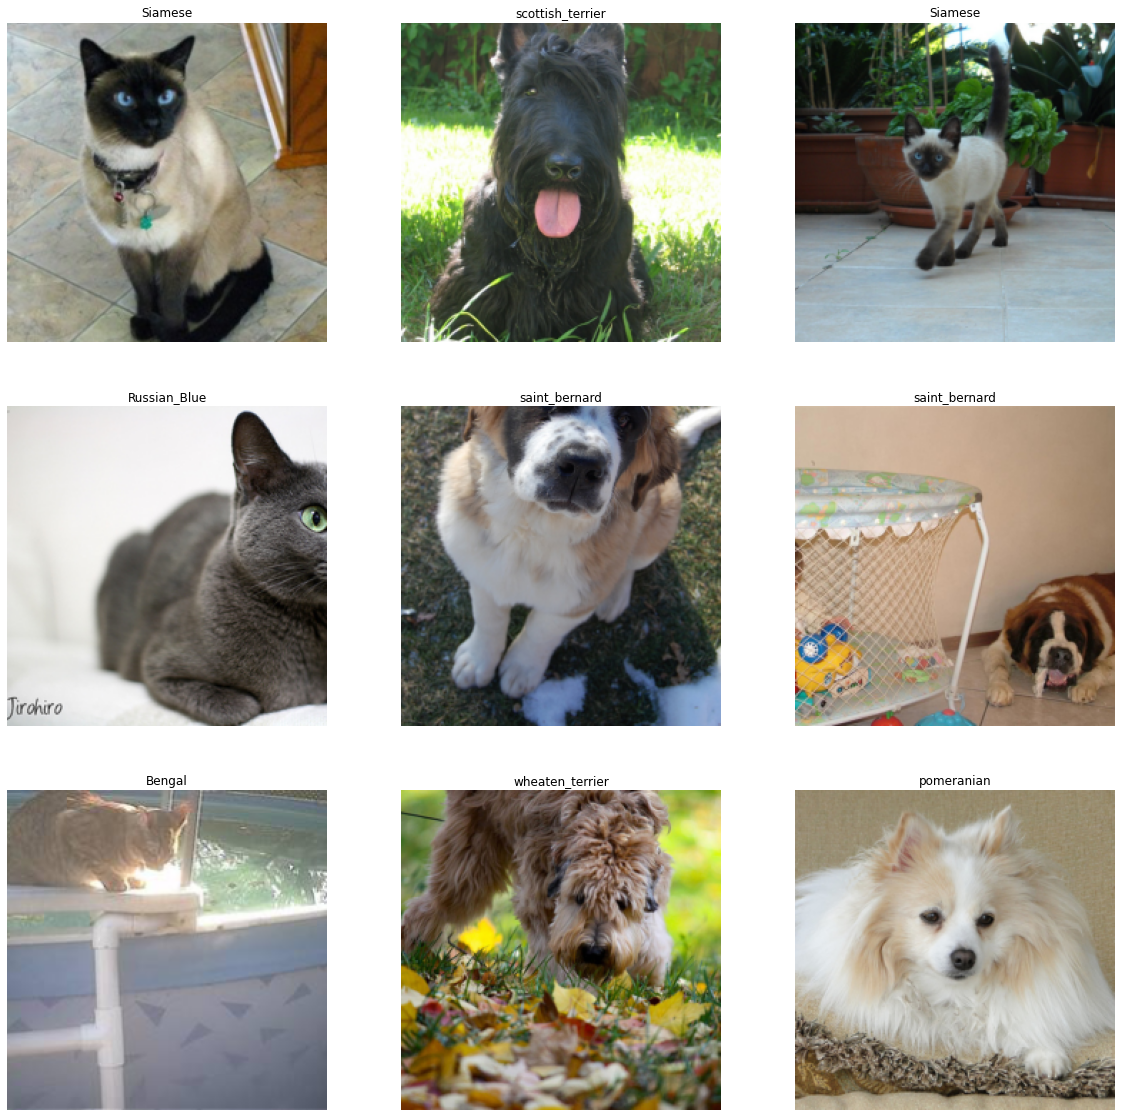

In [233]:
dls_breeds.show_batch(figsize=(20,20))

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our DataLoaders to use data augmentation

In [234]:
dls_breeds_aug = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

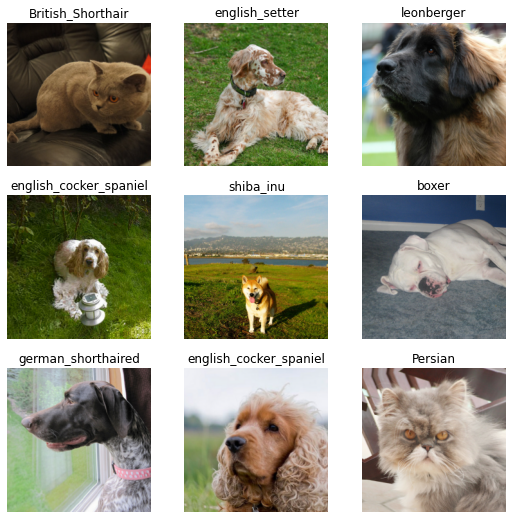

In [235]:
dls_breeds_aug.show_batch()


We can then create our Learner exactly as before and train our model.



In [236]:
learn_breed = cnn_learner(dls_breeds_aug, resnet34, metrics=[error_rate,accuracy])

We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

SuggestedLRs(valley=0.0014454397605732083)

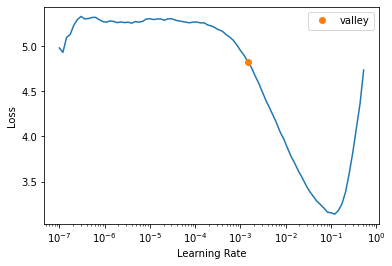

In [237]:
learn_breed.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let's use 3e-3 here. We will also do a bit more epochs:

In [109]:
learn_breed.fine_tune(2, 3e-3)

In [146]:
learn_breed.show_results()

Another thing that is useful is an interpretation object, it can show us where the model made the worse predictions:



In [238]:
interp_breed = Interpretation.from_learner(learn_breed)

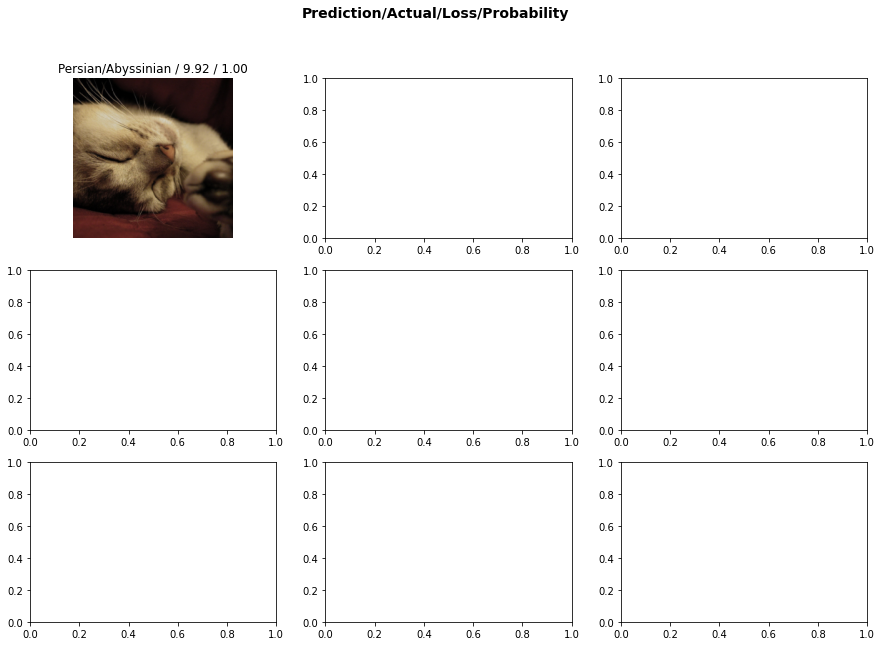

In [120]:
plot_top_losses_breed(learn_breed, k=9, figsize=(15,10))

In [115]:
interp_breed2=ClassificationInterpretation.from_learner(learn_breed)

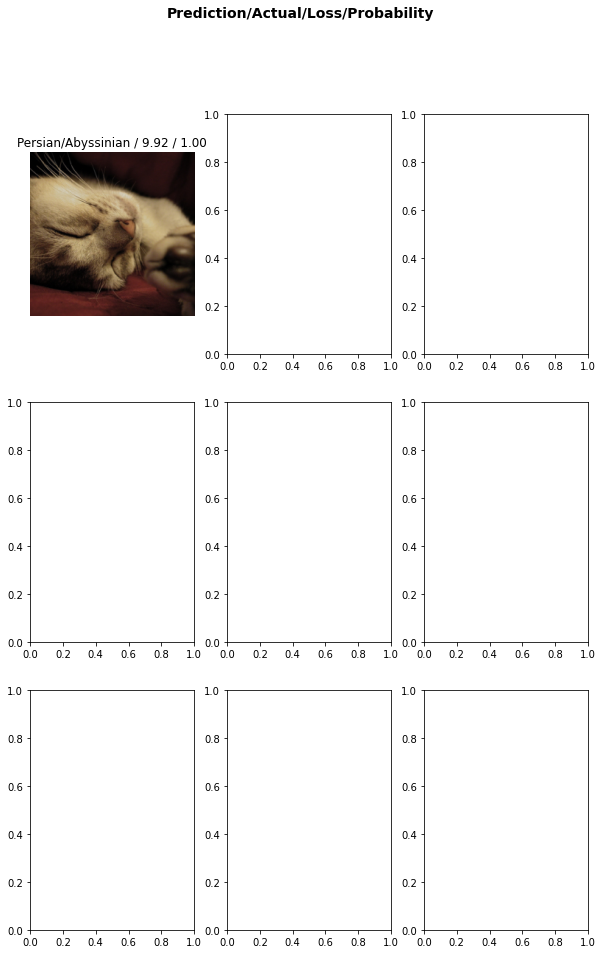

In [116]:
interp_breed2.plot_top_losses(9, figsize=(10,15))

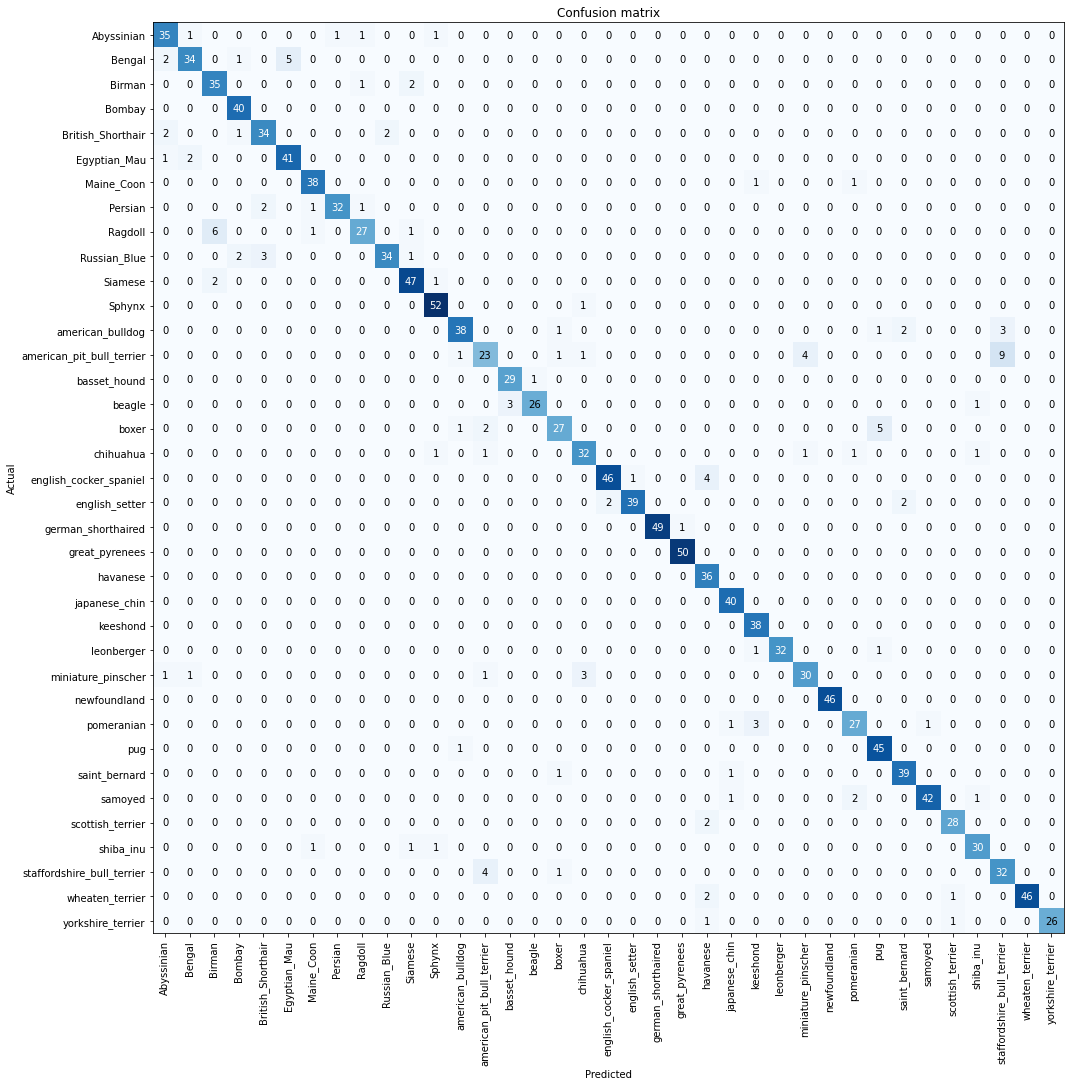

In [121]:
interp_breed2.plot_confusion_matrix(figsize=(15,15))

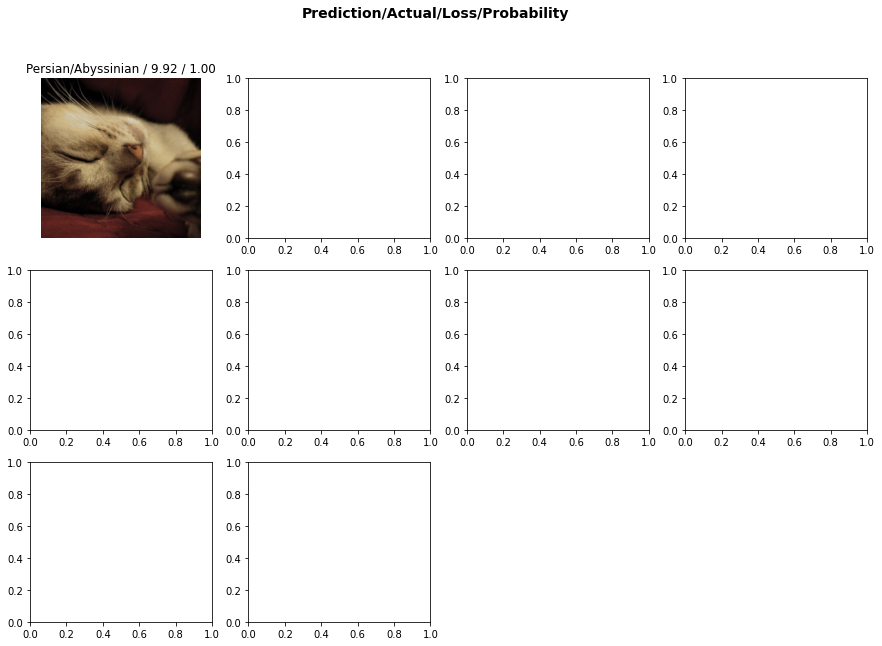

In [144]:
interp_breed2.plot_top_losses(10, figsize=(15,10))

## Multi-label classification

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.csv')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

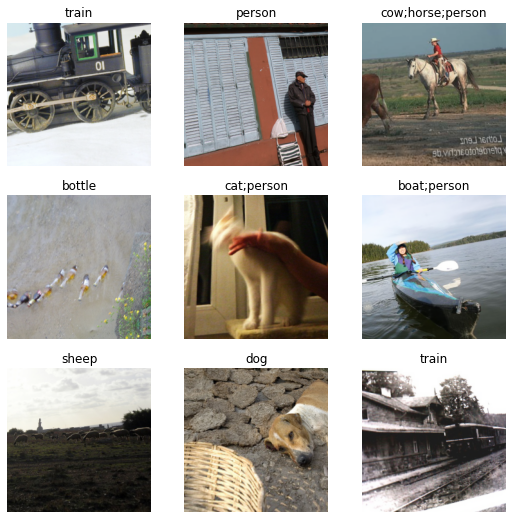

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.033113110810518265)

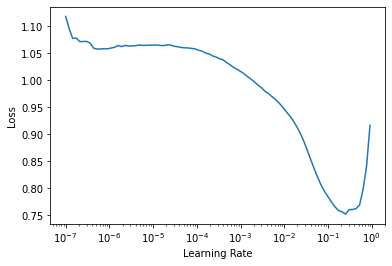

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(2, 3e-2)

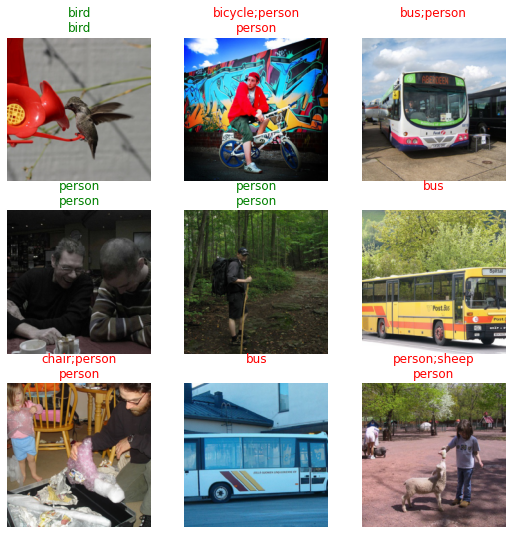

In [ ]:
learn.show_results()

#Fastai Collaborative Filtering


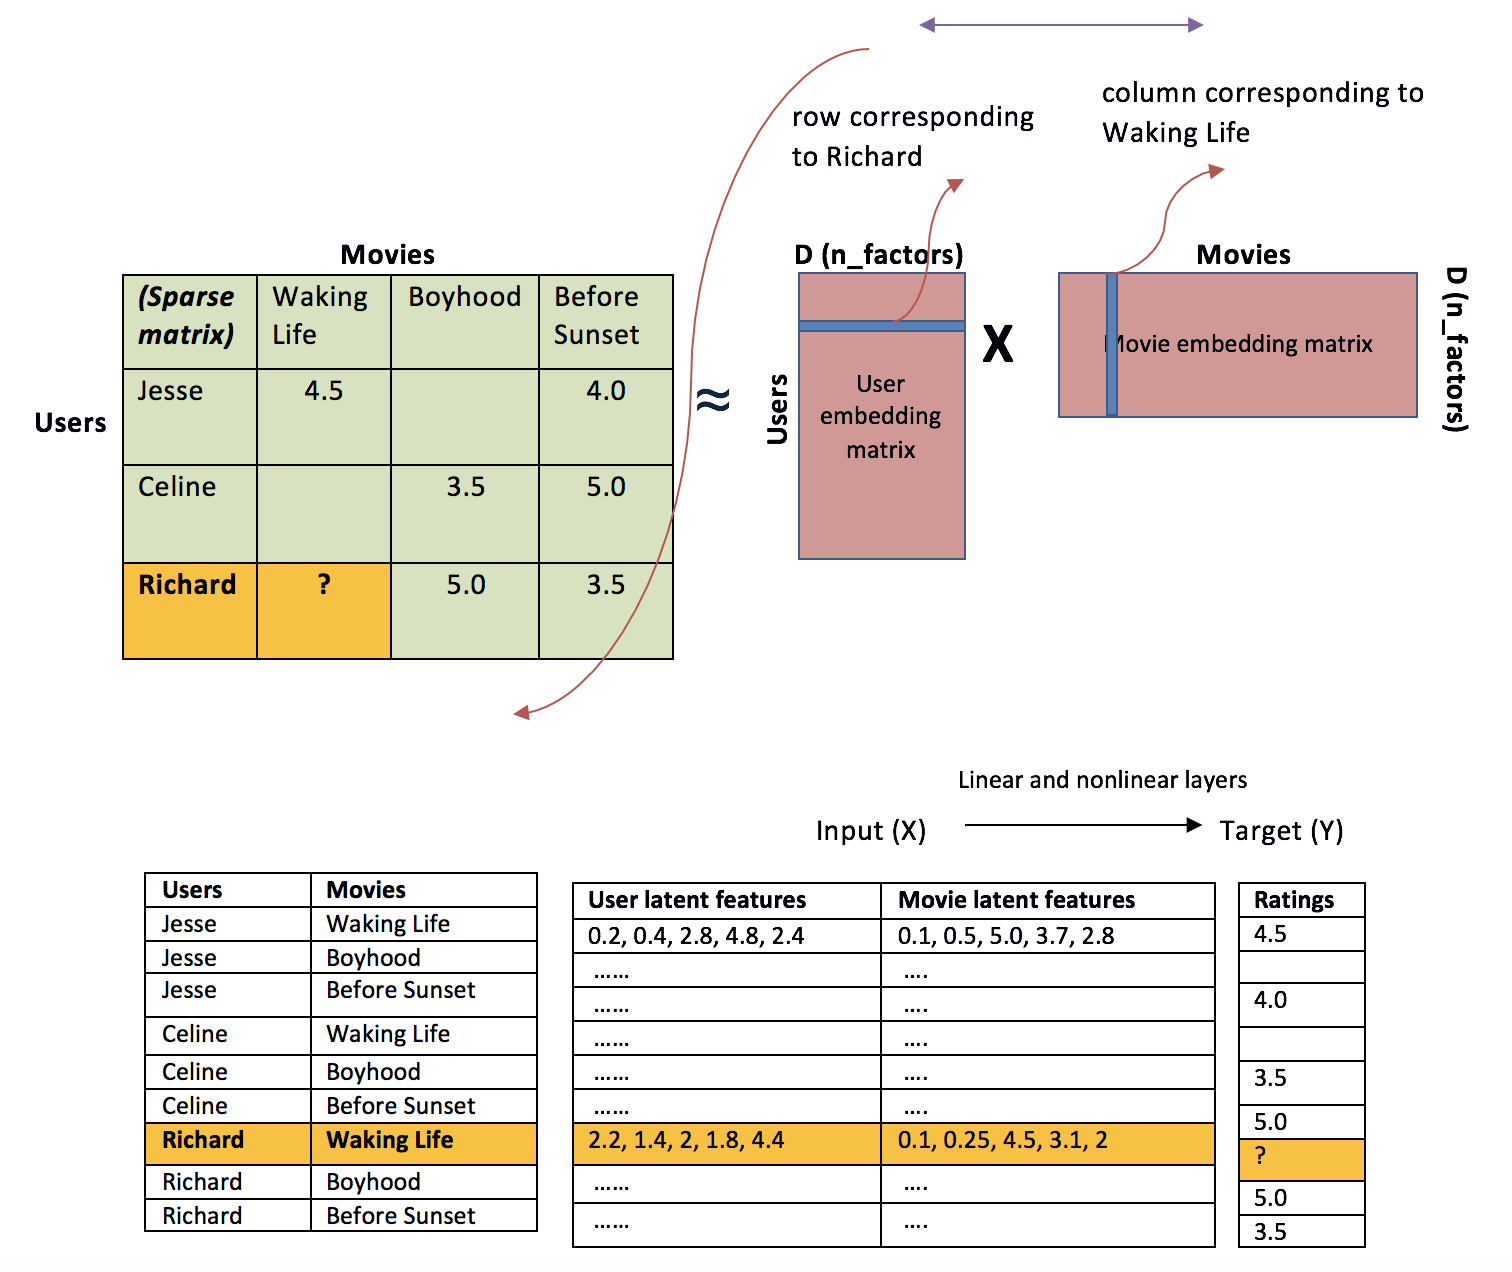

fastai provides two kinds of models for collaborative filtering: a dot-product model and a neural net.



In [40]:
from fastai.tabular.all import *
from fastai.collab import *

Download Movielens 100k dataset https://grouplens.org/datasets/movielens/100k/ 

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:

* 100,000 ratings (1-5) from 943 users on 1682 movies. 

* Each user has rated at least 20 movies. 
    * Simple demographic info for the users (age, gender, occupation, zip)


In [46]:
path = untar_data(URLs.ML_SAMPLE)
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

userId  movieId  rating   timestamp
0      73     1097     4.0  1255504951
1     561      924     3.5  1172695223
2     157      260     3.5  1291598691
3     358     1210     5.0   957481884
4     130      316     2.0  1138999234

The main table is in u.data. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.


In [49]:
path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

user  movie  rating
0   196    242       3
1   186    302       3
2    22    377       1
3   244     51       2
4   166    346       1

Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table u.item:



In [50]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)

In [51]:
ratings = ratings.merge(movies)
ratings.head()

user  movie  rating         title
0   196    242       3  Kolya (1996)
1    63    242       3  Kolya (1996)
2   226    242       5  Kolya (1996)
3   154    242       3  Kolya (1996)
4   306    242       5  Kolya (1996)

In [53]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()


### fastai can create and train a collaborative filtering model by using collab_learner:

In [54]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

`learn.fit_one_cycle(n_epoch, lr_max=None, div=25.0, div_final=100000.0, pct_start=0.25, wd=None, moms=None, cbs=None, reset_opt=False)`

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [43]:
dls = CollabDataLoaders.from_df(ratings, bs=64)
dls.show_batch()

## Collaborative Filtering Interpretation

In [257]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
#Show the top 10 most rated movies
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [258]:
g

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

### Movie bias
Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our top_movies list with the following command:

In [259]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

AttributeError: ignored

Let's compare those biases with the average ratings:



In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:



In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

Or the ones with the best bias



In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]


There is certainly a strong correlation!

Movie weights
Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in top_movies the same way as we did for the bias before.

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

### PCA

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:



In [ ]:
#movie_pca = movie_w.pca(3)
movie_pca.shape

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:


In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


And the worst






In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]


Same thing for the second dimension



In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]


In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

And we can even plot the movies according to their scores on those dimensions:



In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()